In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ann challenge

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ann challenge


## Import Libraries


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print('TensorFlow version:', tf.__version__)
print('Detected GPUs:', tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.14.0
Detected GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
sns.set_theme()

## Auxiliary functions

In [ ]:
def plot_images(X, y, num_images=7, start_index=0) -> None:
  plt.figure(figsize=(12, 12))
  for i in range(num_images**2):
      _ = plt.subplot(num_images, num_images, i + 1)
      plt.imshow(X[start_index+i].astype(np.uint8))
      plt.title(f'{y[start_index+i]}', fontsize=8)
      plt.axis("off")
  plt.show()

In [ ]:
def plot_class_distribution(train_labels, val_labels):
  plt.figure(figsize=(14, 5))
  plt.subplot(1, 2, 1)
  sns.histplot(x=train_labels, hue=train_labels, binwidth=0.5)
  plt.xticks([0, 1], ['healthy', 'unhealthy'])
  plt.title('Training set class distribution')
  plt.xlabel('Class name')
  plt.ylabel('Count')

  plt.subplot(1, 2, 2)
  sns.histplot(x=val_labels, hue=val_labels, binwidth=0.5)
  plt.xticks([0, 1], ['healthy', 'unhealthy'])
  plt.title('Validation set class distribution')
  plt.xlabel('Class name')
  plt.ylabel('Count')
  plt.show()

In [ ]:
def plot_history(history, log_scale: bool = False) -> None:
  acc = history['accuracy']
  val_acc = history['val_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']
  best_epoch = np.argmax(val_acc)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.title('Training and validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')

  if log_scale:
      plt.semilogy(loss, label='Training Loss', color='#ff7f0e')
      plt.semilogy(val_loss, label='Validation Loss', color='#4D61E2')
  else:
      plt.plot(loss, label='Training Loss', color='#ff7f0e')
      plt.plot(val_loss, label='Validation Loss', color='#4D61E2')
  plt.plot(best_epoch, history['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.grid(True)
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Training and validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(acc, label='Training Accuracy', color='#ff7f0e')
  plt.plot(val_acc, label='Validation Accuracy', color='#4D61E2')
  plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.grid(True)
  plt.legend()
  plt.show()

In [ ]:
def print_report(y_true, y_pred):
  true_labels, pred_labels = y_true, np.argmax(y_pred, axis=1)
  print(classification_report(true_labels, pred_labels, target_names=['healthy', 'unhealthy'], digits=4))

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
  labels = ['healthy', 'unhealthy']
  plt.figure(figsize=(8, 7))
  sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels, square=True, cmap='Blues', annot=True, fmt='.0f')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

## Load data

In [ ]:
data = np.load('preprocessed_data_seed_42.npz', allow_pickle=True)

In [ ]:
X_train, X_val, y_train, y_val = data["X_train"], data["X_val"], data["y_train"], data["y_val"]
y_train, y_val = y_train.argmax(axis=1), y_val.argmax(axis=1)

In [ ]:
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (3602, 96, 96, 3)
Training Label Shape: (3602,)
Validation Data Shape: (901, 96, 96, 3)
Validation Label Shape: (901,)


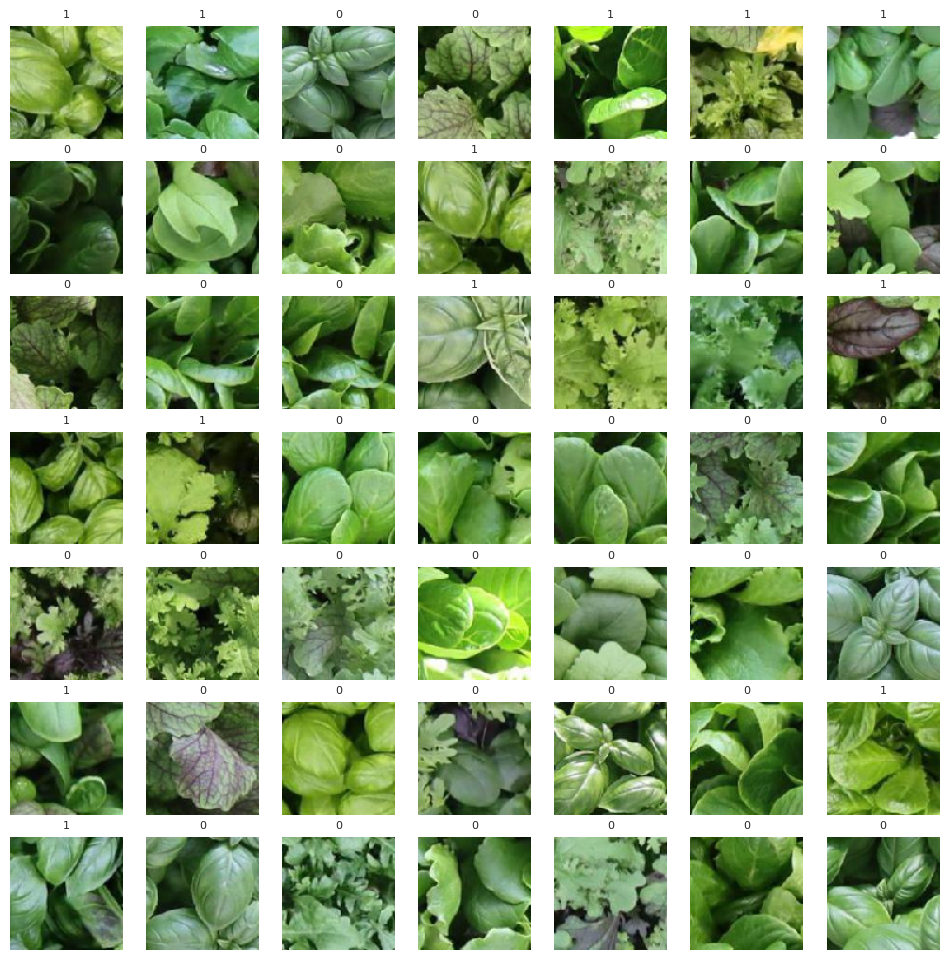

In [ ]:
plot_images(X_train, y_train)

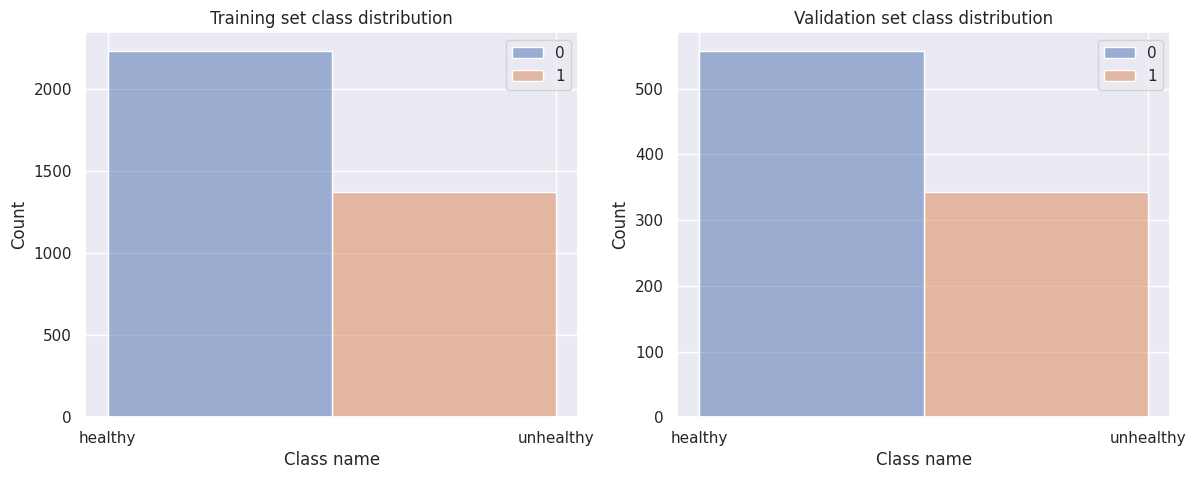

In [ ]:
plot_class_distribution(y_train, y_val)

## Load And Inspect The Model

In [ ]:
model_name = 'efficientnetv2-m'
model = tfk.models.load_model('models/' + model_name)

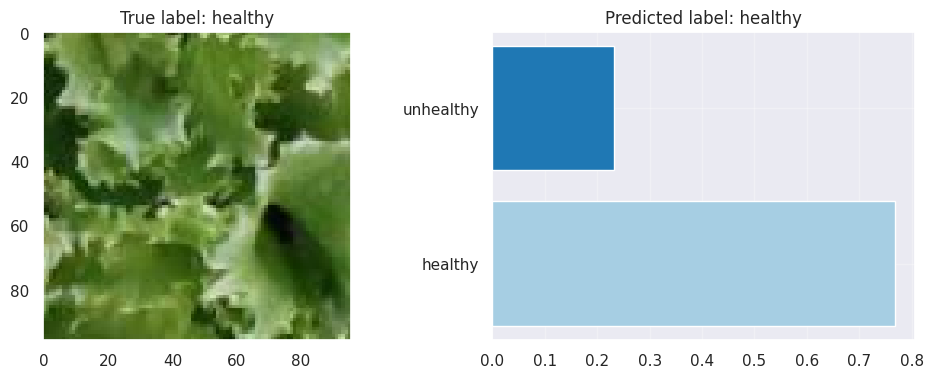

In [ ]:
# Choose a random image for visualization
image = np.random.randint(0, X_val.shape[0])

labels = ['healthy', 'unhealthy']

# Display the input image, true label, and predicted label
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax1.imshow(X_val[image].astype(np.uint8))
ax1.set_title('True label: ' + labels[y_val[image]])
ax1.grid(False)
prediction = model(np.expand_dims(X_val[image], axis=0))
ax2.barh(labels, np.squeeze(tf.nn.softmax(prediction), axis=0), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + labels[np.argmax(prediction)])
ax2.grid(alpha=0.3)
plt.show()

In [ ]:
# Find the samples on which the model failed the prediction
predictions = model.predict(X_val)

29/29 [==============================] - 6s 60ms/step


In [ ]:
mask = predictions.argmax(axis=1) != y_val

X_bad = X_val[mask]
y_bad = y_val[mask]
predictions_bad = predictions[mask]

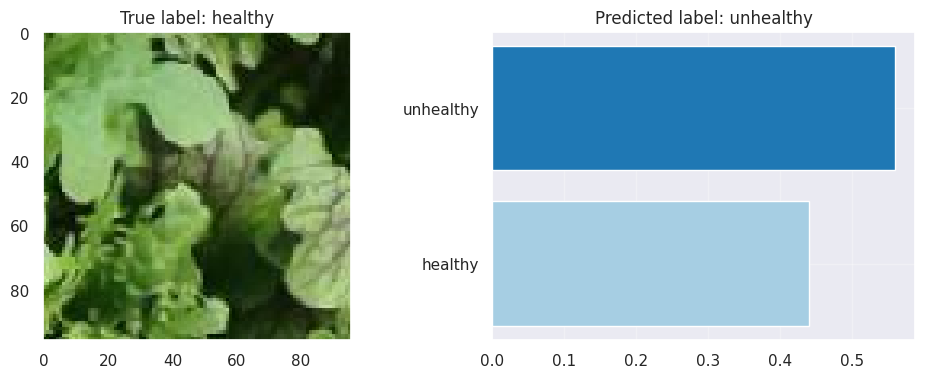

In [ ]:
# Choose a random image for visualization
image = np.random.randint(0, X_bad.shape[0])

labels = ['healthy', 'unhealthy']

# Display the input image, true label, and predicted label
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax1.imshow(X_bad[image].astype(np.uint8))
ax1.set_title('True label: ' + labels[y_bad[image]])
ax1.grid(False)
prediction = predictions_bad[image]
ax2.barh(labels, tf.nn.softmax(prediction), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + labels[np.argmax(prediction)])
ax2.grid(alpha=0.3)
plt.show()